# Validation Analysis - Figures

In [1]:
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# File was manually copied and pasted. Revisit to automatically generate
# wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2.csv')
# wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_by_depth7m.csv')
# wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_by_depth2m.csv')
# wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_Mar10_depthflags.csv')
wq_sst = pd.read_csv('./data/AllTemps_WaterQualityMURGeopolar_March_updated_depthmethod.csv')


In [3]:
# TODO: Move this to previous processing script (ideally never generate the column)
wq_sst = wq_sst.drop('Unnamed: 0', axis=1)

In [4]:
wq_sst

,Station,SampleTime,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst,mur_sst
0,1AAUA001.39,12:10:00,14.50,38.40000,-77.32000,2007-10-29,18.169983,NaN
1,1AAUA001.39,10:35:00,5.20,38.40000,-77.32000,2007-12-10,10.899994,NaN
2,1AAUA001.39,10:30:00,4.90,38.40000,-77.32000,2008-02-04,3.820007,NaN
3,1AAUA001.39,10:22:00,17.40,38.40000,-77.32000,2008-05-19,13.809998,NaN
4,1AAUA001.39,11:00:00,28.10,38.40000,-77.32000,2008-07-28,25.729980,NaN
...,...,...,...,...,...,...,...,...
39007,YRK028.58,09:58:00,29.27,37.48865,-76.74903,2008-07-22,28.339996,27.885986
39008,YRK028.58,10:44:00,26.58,37.48865,-76.74903,2008-08-22,25.359985,26.261993
39009,YRK028.58,10:44:00,25.19,37.48865,-76.74903,2008-09-17,24.929993,23.649994
39010,YRK028.58,10:32:00,21.53,37.48865,-76.74903,2008-10-16,19.669983,21.384003


#### Dropping any dates before 2003-01-01 and after 2019-12-31

Because we don't have MUR past Jan 2020

In [5]:
wq_sst = wq_sst[(wq_sst.SampleDate >= '2003-01-01') & (wq_sst.SampleDate <= '2019-12-31')]
len(wq_sst)

34249

Now there are 34,249 datapoints (dropped 5k points)

## Computing $R^2$ and creating scatter plot

### Preprocessing and $R^2$

In [6]:
def mx_plus_b(x):
    return slope * x + intercept

In [7]:
filtered_mur = wq_sst[~wq_sst['mur_sst'].isnull()]

mur_slope, mur_intercept, r_value, p_value, std_err = scipy.stats.linregress(filtered_mur['MeasureValue'], 
                                                                     filtered_mur['mur_sst'])

print('MUR: slope', mur_slope, 'intercept', mur_intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.9676524744231971 intercept 0.159072412534222 r squared 0.9488223618854158 p_value 0.0


In [8]:
filtered_geop = wq_sst[~wq_sst['geopolar_sst'].isnull()]

gp_slope, gp_intercept, r_value, p_value, std_err = scipy.stats.linregress(filtered_geop['MeasureValue'], 
                                                                     filtered_geop['geopolar_sst'])
print('GEOPOLAR: slope', gp_slope, 'intercept', gp_intercept, 'r squared', r_value**2, 'p_value', p_value)

GEOPOLAR: slope 0.9488932022199913 intercept 0.4751379483792668 r squared 0.9580042335543214 p_value 0.0


**TODO** (if using this figure)
- fix overplotting

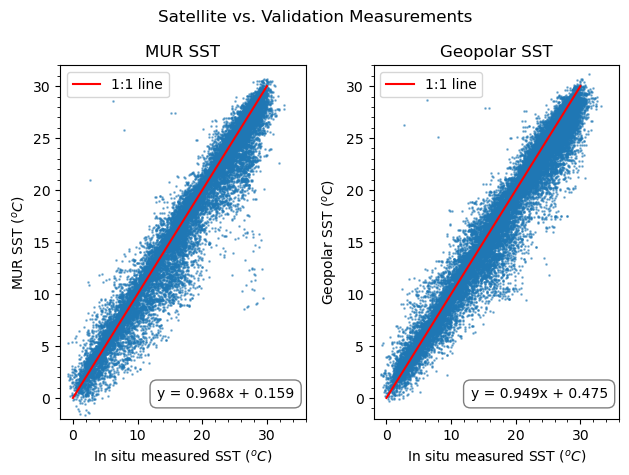

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Satellite vs. Validation Measurements')

bbox_props = {'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.5,
             'pad': 0.5}

filtered_mur.plot.scatter(ax=ax1, x='MeasureValue', y='mur_sst', alpha=0.5, s=0.8)
ax1.set_title('MUR SST')
ax1.set_ylabel('MUR SST ($^oC$)')
ax1.text(13, 0, 'y = {m}x + {b}'.format(m=mur_slope.round(3), 
                                    b=mur_intercept.round(3)),
        bbox=bbox_props)

filtered_geop.plot.scatter(ax=ax2, x='MeasureValue', y='geopolar_sst', alpha=0.5, s=0.8)
ax2.set_title('Geopolar SST')
ax2.set_ylabel('Geopolar SST ($^oC$)')
ax2.text(13, 0, 'y = {m}x + {b}'.format(m=gp_slope.round(3), 
                                    b=gp_intercept.round(3)),
        bbox=bbox_props)

for ax in (ax1, ax2):
    # plot and label the 1:1 line
    ax.plot([0, 30], [0, 30], color='red', label='1:1 line')
    ax.legend(loc="upper left")
    # standardize the axes
    ax.set_xlim([-2, 36])
    ax.set_ylim([-2, 32])
    # label the x axis
    ax.set_xlabel('In situ measured SST ($^oC$)')
    ax.minorticks_on()

fig.tight_layout()
# plt.savefig('./figures/validation_analysis/satellite_validation_scatterplot.jpeg', bbox_inches='tight')

### Preprocessing

In [10]:
wq_sst['geopolar_diff'] = wq_sst['geopolar_sst'] - wq_sst['MeasureValue']
wq_sst['mur_diff'] = wq_sst['mur_sst'] - wq_sst['MeasureValue']

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_47292/2565429290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wq_sst['geopolar_diff'] = wq_sst['geopolar_sst'] - wq_sst['MeasureValue']
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_47292/2565429290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wq_sst['mur_diff'] = wq_sst['mur_sst'] - wq_sst['MeasureValue']


In [11]:
wq_sst[wq_sst.geopolar_diff < -10]

,Station,SampleTime,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst,mur_sst,geopolar_diff,mur_diff
15410,ET1.1,10:42:00,24.6,39.56976,-75.96782,2004-05-13,12.919983,11.851990,-11.680017,-12.748010
15633,ET2.2,09:37:00,25.1,39.46704,-75.87368,2004-05-13,11.820007,NaN,-13.279993,NaN
15668,ET2.2,12:30:00,20.5,39.46704,-75.87368,2007-05-10,10.479980,NaN,-10.020020,NaN
17462,IH5,10:08:00,28.0,38.54966,-77.23917,2004-05-25,17.500000,NaN,-10.500000,NaN
17476,IH6,10:56:00,28.0,38.54455,-77.23460,2004-05-25,17.500000,NaN,-10.500000,NaN
35020,XHG8442,10:01:00,20.8,39.14045,-76.26295,2010-05-05,9.970001,NaN,-10.829999,NaN
36488,XIF4705,10:51:00,21.6,39.24453,-76.49090,2010-05-04,9.459991,NaN,-12.140009,NaN
37363,XKH0375,07:45:00,20.8,39.50530,-76.04140,2010-05-06,10.559998,17.378998,-10.240002,-3.421002
37501,XKH2870,09:00:00,24.4,39.54600,-76.04940,2007-05-21,13.500000,NaN,-10.900000,NaN


In [12]:
temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()
# temps_count = wq_sst.groupby(['Latitude', 'Longitude']).count()

temps_mean = temps_mean.reset_index()
# temps_count = temps_count.reset_index()

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_47292/3748443030.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()


In [13]:
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(temps_mean['Longitude'], temps_mean['Latitude']), 
    crs='epsg:4326'
)

# temps_count_gpd = gpd.GeoDataFrame(
#     temps_count, geometry=gpd.points_from_xy(temps_count['Longitude'], temps_count['Latitude']), 
#     crs='epsg:4326'
# )

In [14]:
# temps_full_gpd = gpd.GeoDataFrame(
#     wq_sst, geometry=gpd.points_from_xy(wq_sst['Longitude'], wq_sst['Latitude']), 
#     crs='epsg:4326'
# )

In [15]:
temps_mean_gpd

,Latitude,Longitude,MeasureValue,geopolar_sst,mur_sst,geopolar_diff,mur_diff,geometry
0,36.85530,-76.06270,20.702444,19.353329,NaN,-1.349115,NaN,POINT (-76.06270 36.85530)
1,36.85732,-76.12025,21.692222,20.572210,NaN,-1.120013,NaN,POINT (-76.12025 36.85732)
2,36.85904,-76.00830,21.797778,19.271111,NaN,-2.526666,NaN,POINT (-76.00830 36.85904)
3,36.86556,-76.32899,17.418380,16.940496,16.781943,-0.477884,-0.587664,POINT (-76.32899 36.86556)
4,36.87361,-76.10696,19.996667,19.456651,NaN,-0.540015,NaN,POINT (-76.10696 36.87361)
...,...,...,...,...,...,...,...,...
508,39.54780,-76.08480,21.242932,19.151197,20.344706,-2.091735,-0.907953,POINT (-76.08480 39.54780)
509,39.54794,-76.08481,18.038462,16.392220,16.940089,-1.646241,-1.105590,POINT (-76.08481 39.54794)
510,39.55830,-75.98670,20.857143,19.109996,20.453663,-1.747147,-0.403480,POINT (-75.98670 39.55830)
511,39.56976,-75.96782,16.569347,15.263963,15.775391,-1.305384,-0.736854,POINT (-75.96782 39.56976)


## Error Histogram

**TODO:** What is the point of the plot? Is it to show that the distribtuion is just a bit wider/narrow in each satellite? Or is it to show that one outlier?

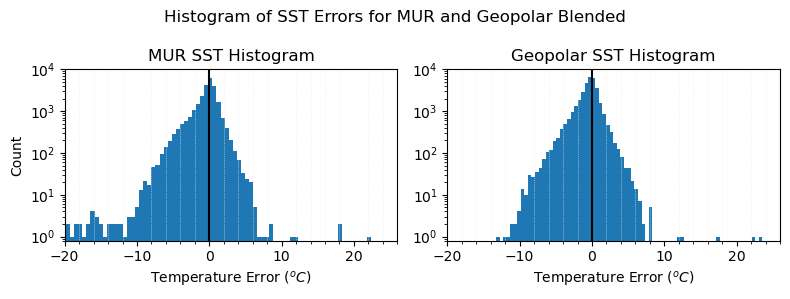

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(8, 3)
fig.suptitle('Histogram of SST Errors for MUR and Geopolar Blended')

wq_sst.geopolar_diff.hist(ax = ax2, bins=75, log=True)
ax2.set_title('Geopolar SST Histogram')

wq_sst.mur_diff.hist(ax = ax1, bins=75, log=True)
ax1.set_title('MUR SST Histogram')
ax1.set_ylabel('Count')

for ax in (ax1, ax2):
    # label x axis
    ax.set_xlabel('Temperature Error ($^oC$)')
    # standardize axes
    # ax.set_xlim([-8, 23])
    # ax.set_ylim([0.9, 130])
    ax.set_xlim([-20, 26])
    ax.set_ylim([0.8, 10000])
    # WHAT TO DO ABOUT GRIDLINES
    # add minor ticks
    # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
    # # Show the minor grid as well. Style it in very light gray as a thin,
    # # dotted line.
    ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(False)
    ax.axvline(0, color='black')

plt.tight_layout()
plt.savefig('./figures/validation_analysis/errors_histogram.png', 
            dpi=400, bbox_inches='tight')

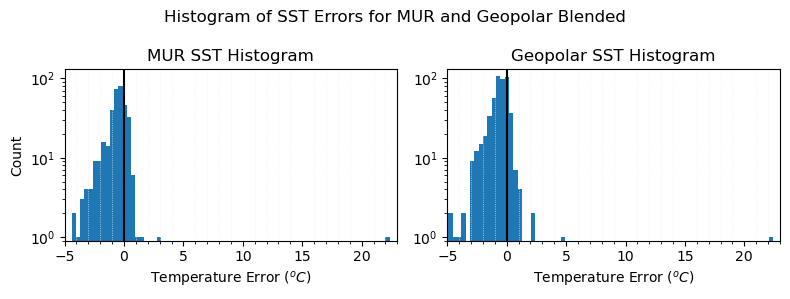

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(8, 3)
fig.suptitle('Histogram of SST Errors for MUR and Geopolar Blended')

temps_mean_gpd.geopolar_diff.hist(ax = ax2, bins=75, log=True)
ax2.set_title('Geopolar SST Histogram')

temps_mean_gpd.mur_diff.hist(ax = ax1, bins=75, log=True)
ax1.set_title('MUR SST Histogram')
ax1.set_ylabel('Count')

for ax in (ax1, ax2):
    # label x axis
    ax.set_xlabel('Temperature Error ($^oC$)')
    # standardize axes
    # ax.set_xlim([-8, 23])
    # ax.set_ylim([0.9, 130])
    ax.set_xlim([-5, 23])
    ax.set_ylim([0.9, 130])
    # WHAT TO DO ABOUT GRIDLINES
    # add minor ticks
    # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
    # # Show the minor grid as well. Style it in very light gray as a thin,
    # # dotted line.
    ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(False)
    ax.axvline(0, color='black')

plt.tight_layout()
plt.savefig('./figures/validation_analysis/errors_histogram.png', 
            dpi=400, bbox_inches='tight')


### Plotting

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

In [18]:
print('Geopolar max/min:', temps_mean_gpd.geopolar_diff.max(), temps_mean_gpd.geopolar_diff.min(), 
     temps_mean_gpd.geopolar_diff.median(), temps_mean_gpd.geopolar_diff.std())
print('MUR max/min:', temps_mean_gpd.mur_diff.max(), temps_mean_gpd.mur_diff.min(),
     temps_mean_gpd.mur_diff.median(), temps_mean_gpd.mur_diff.std())

Geopolar max/min: 22.4300048828125 -4.915004621233259 -0.545192645037616 1.3664435377160336
MUR max/min: 22.355999755859372 -4.3965087890625 -0.4786162651909722 1.5349578316471044


In [19]:
vmin, vmax = -3, 3

In [20]:
norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-5, vmax=5, base=10)

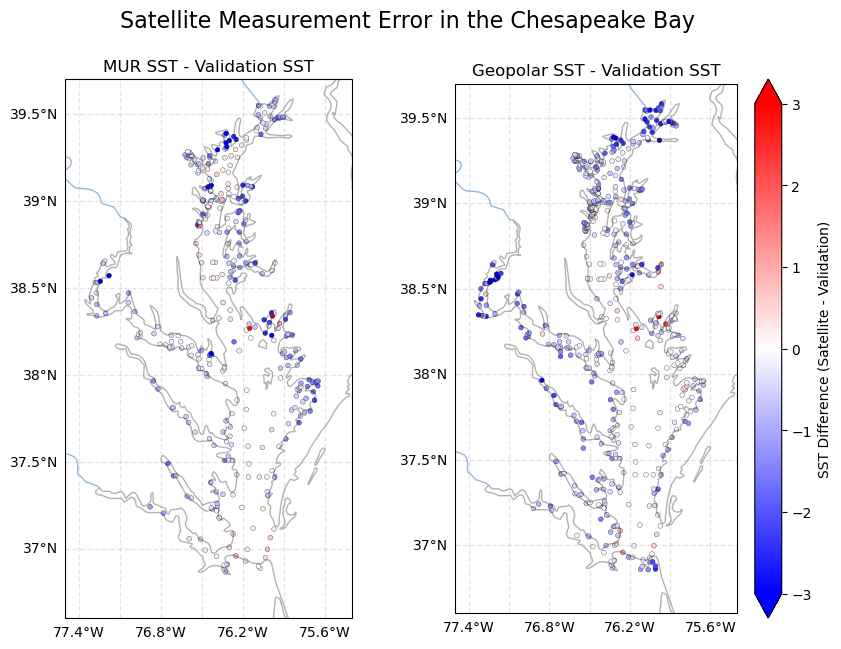

In [27]:
fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 7)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Error in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add MUR to left plot
temps_mean_gpd.plot(ax=axes[0], column='mur_diff', markersize=12, cmap='bwr', 
                    legend_kwds={'label': "SST Difference (MUR - Validation)"}, vmin=vmin, 
                    vmax=vmax, edgecolor='black', linewidth=0.2)
axes[0].set_title('MUR SST - Validation SST', size=12)

# Add Geopolar to right plot
temps_mean_gpd.plot(ax=axes[1], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "SST Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2)
axes[1].set_title('Geopolar SST - Validation SST', size=12)

# save
plt.savefig('./figures/validation_analysis/validation_errors_map.png', dpi=400, bbox_inches='tight')

## RMSE

In [32]:
import numpy as np

In [33]:
N = len(temps_mean_gpd[~temps_mean_gpd['geopolar_diff'].isnull()])

rmse_geopolar = np.sqrt((temps_mean_gpd['geopolar_diff']**2).sum() / N)
print('rmse geopolar: ', rmse_geopolar)

rmse geopolar:  1.4982315561221462


In [34]:
N = len(temps_mean_gpd[~temps_mean_gpd['mur_diff'].isnull()])

rmse_mur = np.sqrt((temps_mean_gpd['mur_diff']**2).sum() / N)
print('rmse mur: ', rmse_mur)

rmse mur:  1.6372880660062015


In [35]:
wq_sst

,Station,SampleTime,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst,mur_sst,geopolar_diff,mur_diff
0,1AAUA001.39,12:10:00,14.50,38.40000,-77.32000,2007-10-29,18.169983,NaN,3.669983,NaN
1,1AAUA001.39,10:35:00,5.20,38.40000,-77.32000,2007-12-10,10.899994,NaN,5.699994,NaN
2,1AAUA001.39,10:30:00,4.90,38.40000,-77.32000,2008-02-04,3.820007,NaN,-1.079993,NaN
3,1AAUA001.39,10:22:00,17.40,38.40000,-77.32000,2008-05-19,13.809998,NaN,-3.590002,NaN
4,1AAUA001.39,11:00:00,28.10,38.40000,-77.32000,2008-07-28,25.729980,NaN,-2.370020,NaN
...,...,...,...,...,...,...,...,...,...,...
39007,YRK028.58,09:58:00,29.27,37.48865,-76.74903,2008-07-22,28.339996,27.885986,-0.930004,-1.384014
39008,YRK028.58,10:44:00,26.58,37.48865,-76.74903,2008-08-22,25.359985,26.261993,-1.220015,-0.318007
39009,YRK028.58,10:44:00,25.19,37.48865,-76.74903,2008-09-17,24.929993,23.649994,-0.260007,-1.540006
39010,YRK028.58,10:32:00,21.53,37.48865,-76.74903,2008-10-16,19.669983,21.384003,-1.860017,-0.145997


#### Using all the datapoints instead of the lat/lon averaged ones

In [36]:
N = len(wq_sst[~wq_sst['geopolar_diff'].isnull()])

rmse_geopolar = np.sqrt((wq_sst['geopolar_diff']**2).sum() / N)
print('rmse geopolar: ', rmse_geopolar)

N = len(wq_sst[~wq_sst['mur_diff'].isnull()])

rmse_mur = np.sqrt((wq_sst['mur_diff']**2).sum() / N)
print('rmse mur: ', rmse_mur)

rmse geopolar:  1.7185016213746476
rmse mur:  1.8979828561562615


## Hovm&#246;ller Plot for Seasonality



In [37]:
def create_hovmoller_matrix(temps, satellite):
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean()
    
    temps = temps[[satellite + '_diff']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    print(satellite, 'min / max', satellite, ':', matrix.min().min(), matrix.max().max())
    print(satellite, 'mean / std', satellite, ':', matrix.mean().mean(), matrix.std().std())
    return matrix

In [38]:
matrix_geop = create_hovmoller_matrix(wq_sst, 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst, 'mur')

geopolar min / max geopolar : -3.4280559037371385 1.7195756912231446
geopolar mean / std geopolar : -0.3085960277659192 0.1885842979573351
mur min / max mur : -5.5609022618007 2.625620241326801
mur mean / std mur : -0.284951562398229 0.4133643281702957


/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_47292/1069195279.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_47292/1069195279.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()


In [39]:
vmin, vmax = -3, 3

In [40]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

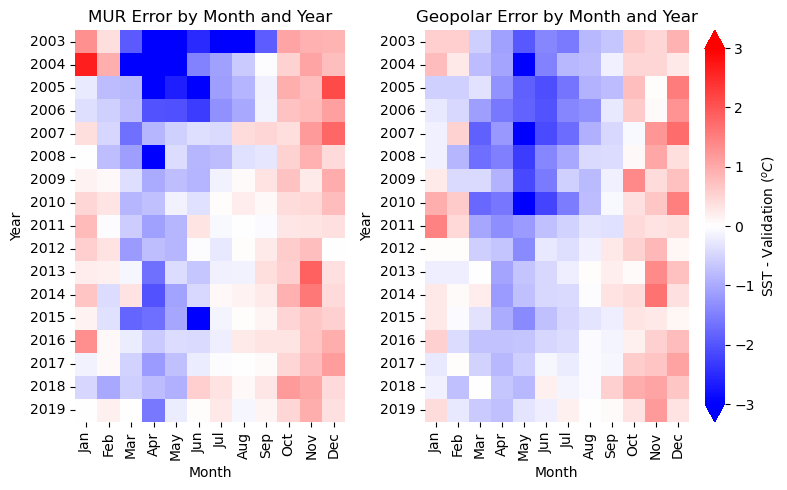

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [1, 1.22]})

# Need to set `cmap=bwr_badgrey` in sns.heatmap() if using this
# bwr_badgrey = plt.cm.get_cmap("bwr").copy()
# bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_mur, ax=ax1, cmap='bwr', vmin=vmin, vmax=vmax,
           cbar=False)

sns.heatmap(matrix_geop, ax=ax2, cmap='bwr', vmin=vmin, vmax=vmax, 
            cbar_kws={'label': 'SST - Validation ($^oC$)', 'extend': 'both'})

for ax in (ax1, ax2):
    ax.set_xticklabels(months, rotation=90)
    ax.set_xlabel('Month')
    ax.set_ylabel('Year')

ax1.set_title('MUR Error by Month and Year')
ax2.set_title('Geopolar Error by Month and Year')


plt.tight_layout()
plt.savefig('./figures/validation_analysis/hovmoller_error.png', dpi=350, 
            bbox_inches='tight')

In [49]:
matrix_mur.where(matrix_mur < -3)

mur_diff                                                                 \
month       1   2         3         4         5         6         7        8    
year                                                                            
2003       NaN NaN       NaN -3.645624 -4.441633       NaN -3.411389 -4.70921   
2004       NaN NaN -3.344331 -4.682524 -5.560902       NaN       NaN      NaN   
2005       NaN NaN       NaN -4.567259       NaN -3.402017       NaN      NaN   
2006       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2007       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2008       NaN NaN       NaN -3.071347       NaN       NaN       NaN      NaN   
2009       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2010       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2011       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2012       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2013       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2014       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2015       NaN NaN       NaN       NaN       NaN -4.186958       NaN      NaN   
2016       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2017       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2018       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   
2019       NaN NaN       NaN       NaN       NaN       NaN       NaN      NaN   

                       
month  9   10  11  12  
year                   
2003  NaN NaN NaN NaN  
2004  NaN NaN NaN NaN  
2005  NaN NaN NaN NaN  
2006  NaN NaN NaN NaN  
2007  NaN NaN NaN NaN  
2008  NaN NaN NaN NaN  
2009  NaN NaN NaN NaN  
2010  NaN NaN NaN NaN  
2011  NaN NaN NaN NaN  
2012  NaN NaN NaN NaN  
2013  NaN NaN NaN NaN  
2014  NaN NaN NaN NaN  
2015  NaN NaN NaN NaN  
2016  NaN NaN NaN NaN  
2017  NaN NaN NaN NaN  
2018  NaN NaN NaN NaN  
2019  NaN NaN NaN NaN

In [48]:
matrix_geop.where(matrix_geop < -3.5)

geopolar_diff                                            
month            1   2   3   4   5   6   7   8   9   10  11  12
year                                                           
2003            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2004            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2005            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2006            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2007            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2008            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2009            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2010            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2011            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2012            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2013            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2014            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2015            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2016            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2017            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2018            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2019            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

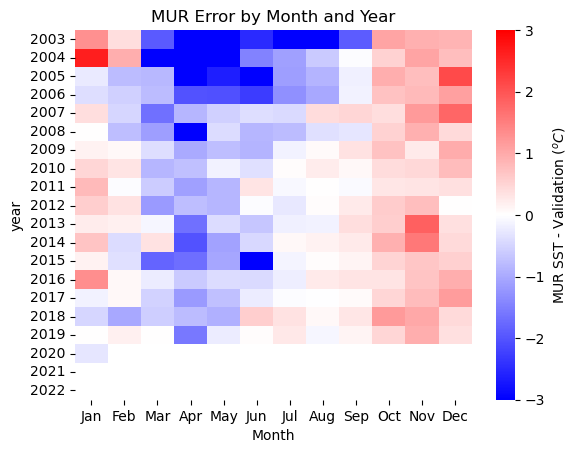

In [66]:
fig, ax = plt.subplots()
sns.heatmap(matrix_mur, cmap='bwr', vmin=vmin, vmax=vmax,
           cbar_kws={'label': 'MUR SST - Validation ($^oC$)'})

ax.set_xticklabels(months, rotation=0)
ax.set_xlabel('Month')

plt.title('MUR Error by Month and Year')

plt.savefig('./figures/validation_analysis/mur_hovmoller_error.png', dpi=350, 
            bbox_inches='tight')

### Quantifying?

Text(2025, 0, 'P Values\nGeopolar: 0.0000579\nMUR:        0.0033')

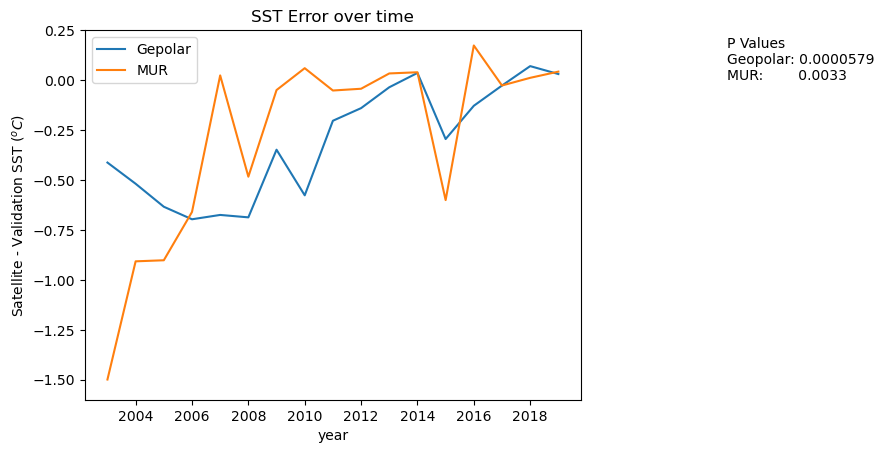

In [34]:
fig, ax = plt.subplots()
matrix_geop.mean(axis=1).plot(ax=ax, label='Gepolar')
ax.set_ylim(-1.6, 0.25)
ax.set_title('SST Error over time')
matrix_mur.mean(axis=1).plot(ax=ax, label='MUR')
ax.legend()
ax.set_ylabel('Satellite - Validation SST ($^oC$)')

plt.text(2025, 0, 'P Values\nGeopolar: 0.0000579\nMUR:        0.0033')

In [35]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(matrix_geop.mean(axis=1), 
                                                                     range(20))

print('MUR: slope', slope, 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 17 and the array at index 1 has size 20

In [ ]:
fig, ax = plt.subplots()
matrix_geop.mean(axis=1).plot(ax=ax, color='black')
matrix_geop.plot(ax=ax, legend=False)
ax.set_ylim(-6, 3)
plt.ylabel('SST Error')
plt.title('Geopolar SST Error over time')

Text(0.5, 1.0, 'MUR SST Error over time')

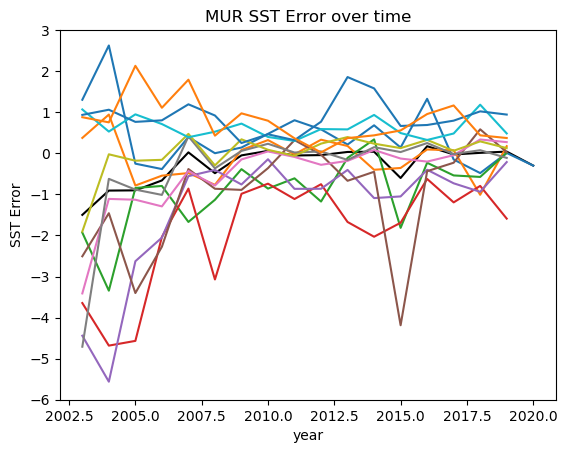

In [30]:
fig, ax = plt.subplots()
matrix_mur.mean(axis=1).plot(ax=ax, color='black')
matrix_mur.plot(ax=ax, legend=False)
ax.set_ylim(-6, 3)
plt.ylabel('SST Error')
plt.title('MUR SST Error over time')

In [36]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(matrix_mur.mean(axis=1).iloc[:18], 
                                                                     range(18))

print('MUR: slope', slope, 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 17 and the array at index 1 has size 18

In [37]:
def linearregression(row):
    _, _, r_value, p_value, _ = scipy.stats.linregress(row.iloc[:17], range(17))
    # pd.DataFrame({'r_squared': r_value**2, 'p_value': p_value})
    return p_value

In [38]:
geo_pvals = matrix_geop.apply(linearregression, axis=0)

In [39]:
mur_pvals = matrix_mur.apply(linearregression, axis=0)

In [40]:
geo_pvals.index = geo_pvals.index.droplevel(0)
mur_pvals.index = mur_pvals.index.droplevel(0)

In [41]:
pd.concat([geo_pvals, mur_pvals], axis=1, keys=['geopolar', 'mur'])

,geopolar,mur
month,,
1,0.932053,0.170615
2,0.310692,0.633589
3,0.114018,0.009608
4,0.008588,0.004868
5,0.000187,0.003537
6,0.000036,0.062766
7,0.000029,0.000381
8,0.000015,0.021855
9,0.001593,0.030425
